### Connect Four

In [766]:
WIDTH = 7
HEIGHT = 6
def init_board():
    return [["0" for j in range(WIDTH)] for i in range(HEIGHT)]

In [767]:
def print_board(board):
    for i in range(HEIGHT):
        l = map(lambda c: board[i][c], range(WIDTH))
        print("|" + " ".join(l) + "|")
    print('-'+WIDTH*'--')
    print('\n')

In [768]:
board = init_board()
print_board(board)

|0 0 0 0 0 0 0|
|0 0 0 0 0 0 0|
|0 0 0 0 0 0 0|
|0 0 0 0 0 0 0|
|0 0 0 0 0 0 0|
|0 0 0 0 0 0 0|
---------------




In [769]:
from copy import deepcopy

def get_available_actions(board):
    res = []
    for column in range(len(board[0])):
        l = [board[i][column] for i in range(len(board))]
        if '0' in l:
            res.append(column)
    return res
get_available_actions(board)

def apply_move(board, move, player):
    new_board = deepcopy(board)

    for i in reversed(range(len(board))):
        if new_board[i][move] == '0':
            new_board[i][move] = player
            return new_board
    raise Exception("Unable to make that move")

In [770]:
print_board(apply_move(board, 3, "R"))

|0 0 0 0 0 0 0|
|0 0 0 0 0 0 0|
|0 0 0 0 0 0 0|
|0 0 0 0 0 0 0|
|0 0 0 0 0 0 0|
|0 0 0 R 0 0 0|
---------------




In [771]:
from functools import reduce

moves = [2, 6, 3, 3, 1, 3, 5, 4, 3, 2, 0]
board_after_moves = reduce(
    lambda b, move_next_turn: apply_move(b, move_next_turn[1], 'R' if move_next_turn[0] % 2 == 0 else 'Y'),
    enumerate(moves), board)
print_board(board_after_moves)


|0 0 0 0 0 0 0|
|0 0 0 0 0 0 0|
|0 0 0 R 0 0 0|
|0 0 0 Y 0 0 0|
|0 0 Y Y 0 0 0|
|R R R R Y R Y|
---------------




In [772]:
def check_winner(board, player):
    for row in range(HEIGHT):
        for col in range(WIDTH - 3): 
            if all(board[row][col + i] == player for i in range(4)):
                return True
    
    for col in range(WIDTH):
        for row in range(HEIGHT - 3):  
            if all(board[row + i][col] == player for i in range(4)):
                return True
    
    for row in range(HEIGHT - 3):
        for col in range(WIDTH - 3):
            if all(board[row + i][col + i] == player for i in range(4)):
                return True

    for row in range(3, HEIGHT):
        for col in range(WIDTH - 3):
            if all(board[row - i][col + i] == player for i in range(4)):
                return True
    
    return False

In [773]:
print(check_winner(board_after_moves, 'R'))
print(check_winner(board_after_moves, 'Y'))

True
False


In [774]:
def check_draw(board, players):
    if check_winner(board, players[0]) is False and check_winner(board, players[1]) is False and not any(["0" in line for line in board]):
        return True
    return False

In [775]:
check_draw(board_after_moves, ['R', 'Y'])

False

In [776]:
# returns "DRAW" or the color of the winning player

def is_final(board, players):
    if check_draw(board, players) is False and check_winner(board, players[0]) is False and check_winner(board, players[1]) is False:
        return False
    if check_winner(board, players[0]) is True:
        return players[0]
    if check_winner(board, players[1]) is True:
        return players[1]
    else:
        return "DRAW"

In [777]:
# simulate random game

from random import choice, random
players = ["R", "Y"]
current_player = "R"
while is_final(board, players) is False:
    actions = get_available_actions(board)
    if not actions:
        break
    action = choice(actions)
    board = apply_move(board, action, current_player)
    current_player = "Y" if current_player == "R" else "R"
    
print_board(board)

|0 0 0 0 0 0 Y|
|0 0 0 0 0 0 R|
|0 0 0 0 0 0 Y|
|0 0 0 0 0 0 Y|
|0 Y R 0 0 0 Y|
|R R R R 0 Y R|
---------------




In [778]:
is_final(board, players)

'R'

## The UCT Algorithm

Algorithms in the MCTS (Monte Carlo Tree Search) family consist of four important stages:
- **Selection** - a strategy for choosing an action to exploit
- **Expansion** - building a new node in the tree
- **Simulation** - running a random playthrough to a terminal state
- **Backpropagation** - updating statistics for all nodes

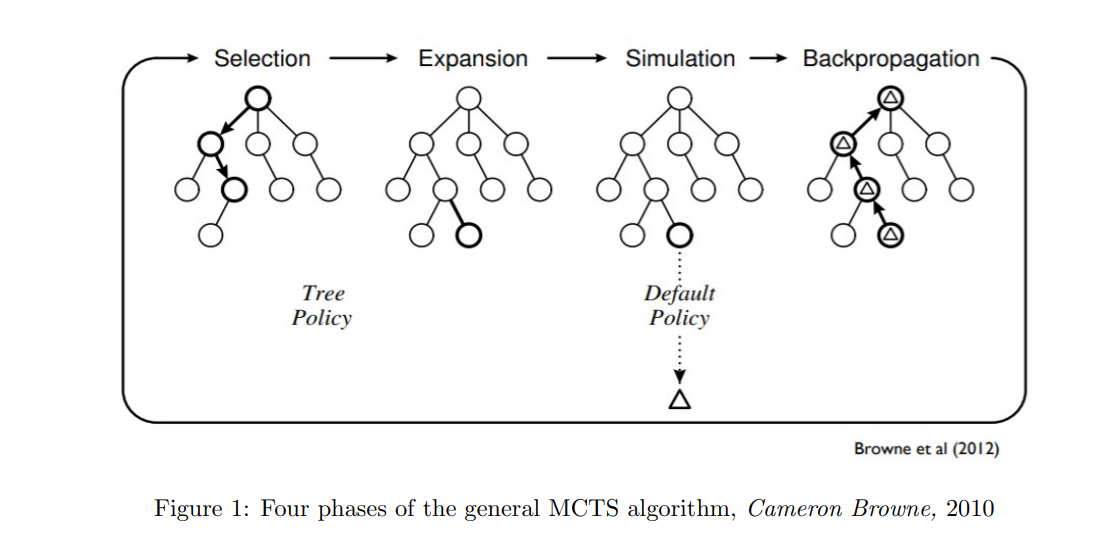

### Node Representation

A node in the state tree is a dictionary containing:
- the number of visits `N` -- how many simulations have been performed from that node or one of its descendants.
- the estimated value `Q` -- an indication of the quality of the node, based on the number of games won from that node.
- a reference to the corresponding state containing the board and the current player -- `STATE`
- a reference to the parent node -- `PARENT`
- the list of children -- `ACTIONS` -- a dictionary containing, for each explored action, a reference to the next node

Example of a node corresponding to a state:

```python
{N: 7, Q: 2.5, STATE: ([[0, 0, 0, 0, 0, 0], ...], "R"), PARENT: None, ACTIONS: {0: {N: 3, ...}, 1: {N: 4, ...}}}
```

In [779]:
def init_node(state, parent = None):
    return {"N": 0, "Q": 0, "STATE": state, "PARENT": parent, "ACTIONS": {}}

Selection is performed on a node where all actions have been explored, choosing the action $a$ that maximizes

$ \frac{Q_a}{N_a} + c \cdot \sqrt{\frac{2 \cdot \log{N_{node}}}{N_a}} $

where $N_a$ and $Q_a$ correspond to the child node of action $a$, and $N_{node}$ corresponds to the node for which we are making the selection (the `node` parameter).

In [780]:
from math import sqrt, log
c = 1.0 / sqrt(2.0)

1. If the algorithm starts with an empty tree (no memory), then a new node is built. Otherwise, select the
subtree according to the opponent’s last action.
2. Until reaching the calculation budget limit:
    1. Starting from the root node, choose the next nodes successively until reaching a final state or a node from which not all possible actions have been explored.
    2. For a node that is not final and from which not all actions have been explored, build a child node for one of the unexplored actions.
    3. Simulate a game from the new node to a final state.
    4. Assess the final status and compute a reward is calculated.
    5. That reward spreads back, updating the statistics (number of visits) for each node to the root.
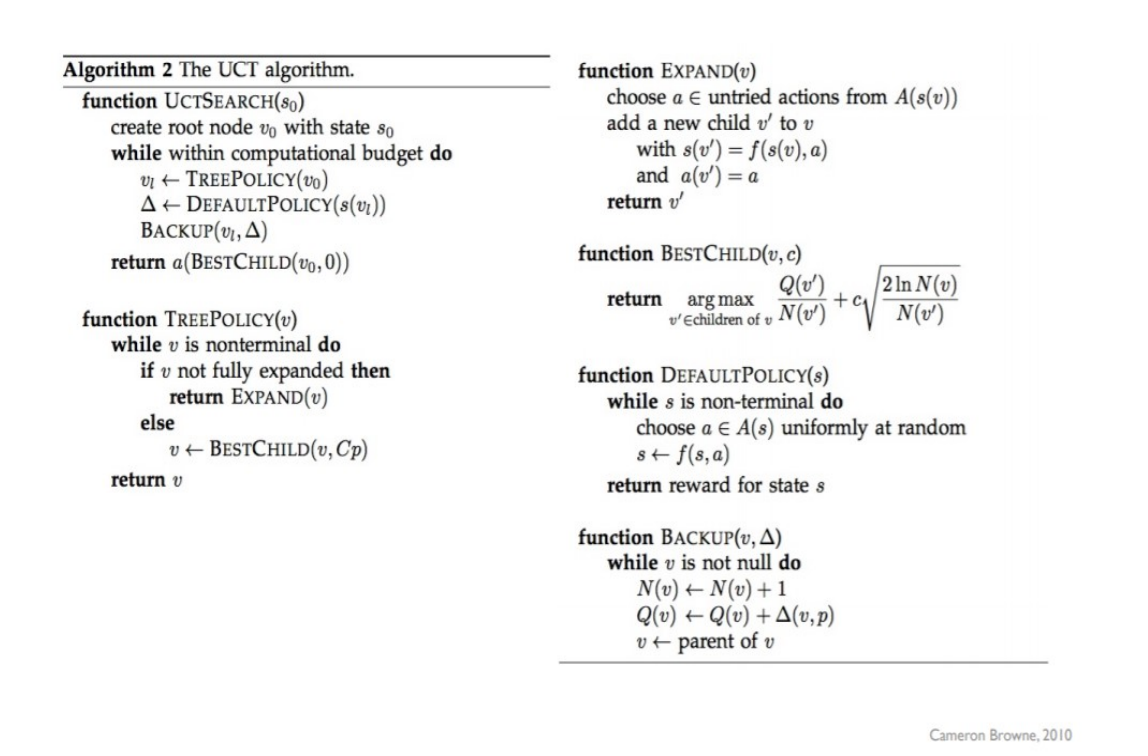

### Task 0 - 7p
Implement the algorithm Upper Confidence Bound for Trees from the Monte Carlo Tree Search Algorithm
family.


In [781]:
from random import choice

CP = 1.414 

def UCT_search(root_state, computational_budget=40):
    root = init_node(root_state)
    for _ in range(computational_budget):
        v1 = tree_policy(root)  
        delta = default_policy(v1["STATE"])
        backup(v1, delta) 
    return max(root["ACTIONS"], key=lambda action: root["ACTIONS"][action]["N"])

def tree_policy(v):
    while not is_final(v["STATE"], ["R", "Y"]):
        if not fully_expanded(v):
            return expanded(v)
        else:
            v = best_child(v, CP)
    return v

def fully_expanded(v):
    return len(v["ACTIONS"]) == len(get_available_actions(v["STATE"]))

def expanded(v):
    untried_actions = [a for a in get_available_actions(v["STATE"]) if a not in v["ACTIONS"]]
    action = choice(untried_actions)
    new_state = apply_move(v["STATE"], action, current_player(v))
    child_node = init_node(new_state, v)
    v["ACTIONS"][action] = child_node
    return child_node

def best_child(v, c):
    def ucb1(node):
        q = node["Q"] / node["N"]
        u = c * sqrt(log(v["N"]) / node["N"])
        return q + u
    return max(v["ACTIONS"].values(), key=ucb1)


def current_player(node):
    # count the number that each player took
    r_moves = sum(row.count("R") for row in node["STATE"])
    y_moves = sum(row.count("Y") for row in node["STATE"])
    
    # since Red is starting, he should always be one move ahead of Yellow
    return "R" if r_moves == y_moves else "Y"

def default_policy(state):

    players = ["R", "Y"]
    current = current_player({"STATE": state})  
    simulation_state = deepcopy(state)
    while not is_final(simulation_state, players):
        actions = get_available_actions(simulation_state)
        if not actions:
            break
        action = choice(actions)
        simulation_state = apply_move(simulation_state, action, current)
        current = "Y" if current == "R" else "R"
    winner = is_final(simulation_state, players)
    if winner == "R":
        return 1  
    elif winner == "Y":
        return -1 
    else:
        return 0  

def backup(v, delta):
    while v is not None:
        v["N"] += 1
        v["Q"] += delta
        delta = -delta  
        v = v["PARENT"]


### Task 1 - 3p
Set up a match between two players where they play against each other for *n* games (for instance n = 30). Assign each player a different computational budget, for example, a budget of 5 for the player with red pieces and a budget of 40 for the player with yellow pieces. Gather statistics across the *n* games, noting how many end in a win for each player and how many result in a draw. Test this setup with 3 different budget pairs for our players. Display the results in a clear format.

In [782]:
# modify this values for different results
yellow_budget = 5
red_budget = 40
number_of_games = 5

# game stats
red_wins = 0
yellow_wins = 0
draws = 0

for game in range(1, number_of_games + 1):
    print("Playing Game: {} out of {}".format(game, number_of_games))
    board = init_board()  
    current_player_gaming = "Y" 
    while is_final(board, players) is False:
        if not actions:
            break
        
        action = UCT_search(board, current_budget)
        board = apply_move(board, action, current_player_gaming)
        current_player_gaming = "Y" if current_player_gaming == "R" else "R"
        current_budget = 40 if current_player_gaming == "R" else 5
    
    # check the final state of the board
    winner = is_final(board, players)
    if winner == "R":
        # if Red wins
        red_wins += 1
        print("Red wins game nr. {}".format(game))
    elif winner == "Y": 
        # if Yellow wins
        yellow_wins += 1
        print("Yellow wins game nr. {}".format(game))
    else:
        # if we have a draw
        draws += 1
        print("Draw!")
    
# final stats for the games
print("------------------------")
print("For a number of {} games:".format(number_of_games))
print("Number of wins for Red, which has a budget of {} computational units: {}".format(red_budget, red_wins))
print("Number of wins for Yellow, which has a budget of {} computational units: {}".format(yellow_budget, yellow_wins))
print("Number of draws: {}".format(draws))

"""
My observations: 
At least for the values of 5 and 40 or the computational budget, usually the player that goes first has a higher winning rate.
"""

Playing Game: 1 out of 5
Red wins game nr. 1
Playing Game: 2 out of 5
Yellow wins game nr. 2
Playing Game: 3 out of 5
Red wins game nr. 3
Playing Game: 4 out of 5
Red wins game nr. 4
Playing Game: 5 out of 5
Yellow wins game nr. 5
------------------------
For a number of 5 games:
Number of wins for Red, which has a budget of 40 computational units: 3
Number of wins for Yellow, which has a budget of 5 computational units: 2
Number of draws: 0


'\nMy observations: \nAt least for the values of 5 and 40 or the computational budget, usually the player that goes first has a higher winning rate.\n'